# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [5]:
X_val_feats.shape

(1000, 155)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-5, 1e-4, 5e-4]
regularization_strengths = [0, 1, 10, 100, 1000, 5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"training lr: {lr}, reg: {reg}")
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True)
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        print('training accuracy: %f' % train_acc)
        print('validation accuracy: %f' % val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
                            
        results[(lr, reg)] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

training lr: 5e-05, reg: 0
iteration 0 / 1500: loss 9.023084
iteration 100 / 1500: loss 8.668881
iteration 200 / 1500: loss 8.304656
iteration 300 / 1500: loss 7.952029
iteration 400 / 1500: loss 7.575420
iteration 500 / 1500: loss 7.287484
iteration 600 / 1500: loss 7.091835
iteration 700 / 1500: loss 6.891864
iteration 800 / 1500: loss 6.486425
iteration 900 / 1500: loss 5.975795
iteration 1000 / 1500: loss 5.952649
iteration 1100 / 1500: loss 5.743528
iteration 1200 / 1500: loss 5.762328
iteration 1300 / 1500: loss 5.747792
iteration 1400 / 1500: loss 5.449651
training accuracy: 0.429857
validation accuracy: 0.432000
training lr: 5e-05, reg: 1
iteration 0 / 1500: loss 9.002390
iteration 100 / 1500: loss 8.652117
iteration 200 / 1500: loss 8.327891
iteration 300 / 1500: loss 7.773846
iteration 400 / 1500: loss 7.699903
iteration 500 / 1500: loss 7.531937
iteration 600 / 1500: loss 6.996703
iteration 700 / 1500: loss 6.953268
iteration 800 / 1500: loss 6.789140
iteration 900 / 1500: l

iteration 1100 / 1500: loss 357.465243
iteration 1200 / 1500: loss 385.340039
iteration 1300 / 1500: loss 412.345089
iteration 1400 / 1500: loss 436.788978
training accuracy: 0.449531
validation accuracy: 0.444000
training lr: 0.0001, reg: 50000.0
iteration 0 / 1500: loss 83.307573
iteration 100 / 1500: loss 430.273390
iteration 200 / 1500: loss 1438.366247
iteration 300 / 1500: loss 3056.830109
iteration 400 / 1500: loss 5032.671312
iteration 500 / 1500: loss 7037.536667
iteration 600 / 1500: loss 9047.277382
iteration 700 / 1500: loss 10968.340421
iteration 800 / 1500: loss 12772.961583
iteration 900 / 1500: loss 14465.795013
iteration 1000 / 1500: loss 16071.603195
iteration 1100 / 1500: loss 17583.463317
iteration 1200 / 1500: loss 19026.401270
iteration 1300 / 1500: loss 20340.096735
iteration 1400 / 1500: loss 21573.265358
training accuracy: 0.449735
validation accuracy: 0.445000
training lr: 0.0001, reg: 500000.0
iteration 0 / 1500: loss 795.221592
iteration 100 / 1500: loss 428

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.471


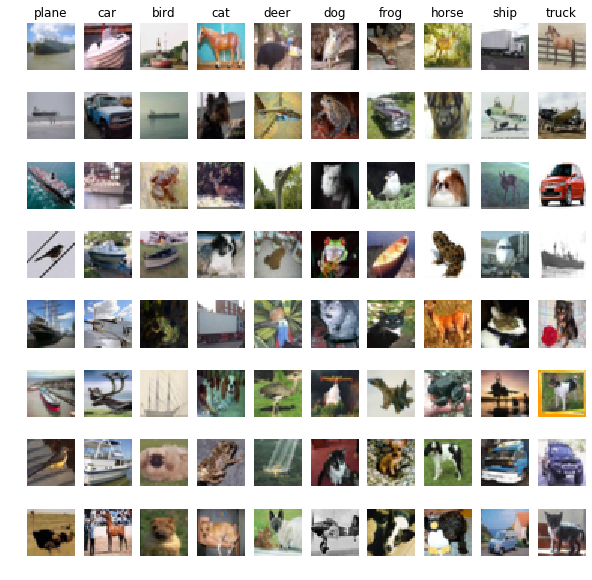

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

plt.figure(figsize=(10,10))
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
Yes, they do. For example, images that are misclassified as "plane" often have the sky in the background, which could trick the model. Also, trucks and cars as well as animal types are often mixed, which is expected.



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [31]:
X_test_feats.shape

(1000, 154)

In [37]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10
hidden_sizes = [100, 200, 400]
num_iters = 2000
lr_decays = [0.95]
regs = [1e-3, 0.01, 0.1, 1, 100]
learning_rates = [1e-2, 0.1, 1, 3]

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_acc = 0
for hidden_size in hidden_sizes:
    for decay in lr_decays:
        for reg in regs:
            for learning_rate in learning_rates:
                print(f"training H: {hidden_size}, decay: {decay}, reg: {reg}, lr: {learning_rate}")

                net = TwoLayerNet(input_dim, hidden_size, num_classes)

                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=num_iters, batch_size=200,
                            learning_rate=learning_rate, learning_rate_decay=decay,
                            reg=reg, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print('Validation accuracy: ', val_acc)
                
                if val_acc > best_acc:
                    best_net = net
                    best_acc = val_acc


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


training H: 100, decay: 0.95, reg: 0.001, lr: 0.01
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302624
iteration 200 / 2000: loss 2.302451
iteration 300 / 2000: loss 2.302443
iteration 400 / 2000: loss 2.302516
iteration 500 / 2000: loss 2.302619
iteration 600 / 2000: loss 2.302348
iteration 700 / 2000: loss 2.302276
iteration 800 / 2000: loss 2.302611
iteration 900 / 2000: loss 2.302901
iteration 1000 / 2000: loss 2.302278
iteration 1100 / 2000: loss 2.302319
iteration 1200 / 2000: loss 2.302338
iteration 1300 / 2000: loss 2.302107
iteration 1400 / 2000: loss 2.301976
iteration 1500 / 2000: loss 2.300899
iteration 1600 / 2000: loss 2.300563
iteration 1700 / 2000: loss 2.299006
iteration 1800 / 2000: loss 2.297467
iteration 1900 / 2000: loss 2.295100
Validation accuracy:  0.191
training H: 100, decay: 0.95, reg: 0.001, lr: 0.1
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.301693
iteration 200 / 2000: loss 2.237195
iteration 300 / 2000: loss 1.941679
i

iteration 400 / 2000: loss 2.198396
iteration 500 / 2000: loss 2.174491
iteration 600 / 2000: loss 2.177752
iteration 700 / 2000: loss 2.164488
iteration 800 / 2000: loss 2.151745
iteration 900 / 2000: loss 2.193682
iteration 1000 / 2000: loss 2.227117
iteration 1100 / 2000: loss 2.159890
iteration 1200 / 2000: loss 2.213601
iteration 1300 / 2000: loss 2.174045
iteration 1400 / 2000: loss 2.179318
iteration 1500 / 2000: loss 2.164060
iteration 1600 / 2000: loss 2.189403
iteration 1700 / 2000: loss 2.164268
iteration 1800 / 2000: loss 2.152619
iteration 1900 / 2000: loss 2.169133
Validation accuracy:  0.257
training H: 100, decay: 0.95, reg: 0.1, lr: 3
iteration 0 / 2000: loss 2.302602
iteration 100 / 2000: loss 2.311898
iteration 200 / 2000: loss 2.605713
iteration 300 / 2000: loss 2.261224
iteration 400 / 2000: loss 2.301482
iteration 500 / 2000: loss 2.307372
iteration 600 / 2000: loss 2.306661
iteration 700 / 2000: loss 2.297237
iteration 800 / 2000: loss 2.305805
iteration 900 / 20

/Users/dziugas/Documents/code/stanford_cs231/assignment1/cs231n/classifiers/neural_net.py:259: RuntimeWarning: invalid value encountered in true_divide
  return exp / exp_sum
/Users/dziugas/Documents/code/stanford_cs231/assignment1/cs231n/classifiers/neural_net.py:105: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(target_probabilities))
/Users/dziugas/Documents/code/stanford_cs231/assignment1/cs231n/classifiers/neural_net.py:125: RuntimeWarning: invalid value encountered in greater
  first_activation_gradient = errors.dot(W2.T) * (first_activation > 0)


iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
Validation accuracy:  0.087
training H: 100, decay: 0.95, reg: 1, lr: 3
iteration 0 / 2000: loss 2.302750
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 /

iteration 1900 / 2000: loss 2.296709
Validation accuracy:  0.144
training H: 200, decay: 0.95, reg: 0.01, lr: 0.1
iteration 0 / 2000: loss 2.302589
iteration 100 / 2000: loss 2.304128
iteration 200 / 2000: loss 2.211898
iteration 300 / 2000: loss 1.945242
iteration 400 / 2000: loss 1.762541
iteration 500 / 2000: loss 1.671644
iteration 600 / 2000: loss 1.737264
iteration 700 / 2000: loss 1.752070
iteration 800 / 2000: loss 1.633373
iteration 900 / 2000: loss 1.708721
iteration 1000 / 2000: loss 1.613427
iteration 1100 / 2000: loss 1.599372
iteration 1200 / 2000: loss 1.652852
iteration 1300 / 2000: loss 1.502326
iteration 1400 / 2000: loss 1.621985
iteration 1500 / 2000: loss 1.615573
iteration 1600 / 2000: loss 1.586859
iteration 1700 / 2000: loss 1.482147
iteration 1800 / 2000: loss 1.551232
iteration 1900 / 2000: loss 1.527244
Validation accuracy:  0.506
training H: 200, decay: 0.95, reg: 0.01, lr: 1
iteration 0 / 2000: loss 2.302588
iteration 100 / 2000: loss 1.712900
iteration 200

iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
Validation accuracy:  0.087
training H: 200, decay: 0.95, reg: 100, lr: 0.01
iteration 0 / 2000: loss 2.335634
iteration 100 / 2000: loss 2.302376
iteration 200 / 2000: loss 2.302734
iteration 300 / 2000: loss 2.302234
iteration 400 / 2000: loss 2.302689
iteration 500 / 2000: loss 2.302682
iteration 600 / 2000: loss 2.302346
iteration 700 / 2000: loss 2.302937
iteration 800 / 2000: loss 2.302236
iteration 900 / 2000: loss 2.302948
iteration 1000 / 2000: loss 2.302796
iteration 1100 / 2000: loss 2.302741
iteration 1200 / 2000: loss 2.302087
iteration 1300 / 2000: loss 2.302338
iteration 1400 / 2000: loss 2.30273

iteration 100 / 2000: loss 1.607155
iteration 200 / 2000: loss 1.734230
iteration 300 / 2000: loss 1.795711
iteration 400 / 2000: loss 1.590663
iteration 500 / 2000: loss 1.604574
iteration 600 / 2000: loss 1.618079
iteration 700 / 2000: loss 1.648896
iteration 800 / 2000: loss 1.615136
iteration 900 / 2000: loss 1.652994
iteration 1000 / 2000: loss 1.597100
iteration 1100 / 2000: loss 1.546896
iteration 1200 / 2000: loss 1.670309
iteration 1300 / 2000: loss 1.544125
iteration 1400 / 2000: loss 1.676335
iteration 1500 / 2000: loss 1.650683
iteration 1600 / 2000: loss 1.579708
iteration 1700 / 2000: loss 1.748324
iteration 1800 / 2000: loss 1.630777
iteration 1900 / 2000: loss 1.511125
Validation accuracy:  0.508
training H: 400, decay: 0.95, reg: 0.01, lr: 3
iteration 0 / 2000: loss 2.302592
iteration 100 / 2000: loss 2.181215
iteration 200 / 2000: loss 2.066327
iteration 300 / 2000: loss 1.919195
iteration 400 / 2000: loss 2.183152
iteration 500 / 2000: loss 1.936178
iteration 600 / 2

iteration 1100 / 2000: loss 2.302946
iteration 1200 / 2000: loss 2.302171
iteration 1300 / 2000: loss 2.302614
iteration 1400 / 2000: loss 2.302475
iteration 1500 / 2000: loss 2.302314
iteration 1600 / 2000: loss 2.302269
iteration 1700 / 2000: loss 2.302813
iteration 1800 / 2000: loss 2.302587
iteration 1900 / 2000: loss 2.302202
Validation accuracy:  0.087
training H: 400, decay: 0.95, reg: 100, lr: 0.1
iteration 0 / 2000: loss 2.367857
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000:

In [38]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.569
